In [1]:
# standard imports
import pandas as pd
import numpy as np

# specific libaries
import glob                                     # read all csv files in the directory
import os                                       # for using OS functions
import warnings                                 # for suppression of depricated messages          
import pandas_profiling                         # needs prior install
from methods import *                           # selfmade functions and methods
from geopy.geocoders import Nominatim
from tqdm import tqdm


# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pygal
from keplergl import KeplerGl
from matplotlib.gridspec import GridSpec
from wordcloud import STOPWORDS

# ML - PreProcessing
from sklearn.utils import resample

In [2]:
# define global styling params
rcParams = {
    "axes.titlesize" : 20,
    "axes.titleweight" :"bold",
    "axes.labelsize" : 12,
    "lines.linewidth" : 3,
    "lines.markersize" : 10,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "patches.labelsize": 12,
    "axes.small_titlesize" : 10,
    "axes.small_titleweight" :"bold",
    "axes.small_labelsize" : 8,
    "lines.small_linewidth" : 3,
    "lines.small_markersize" : 8,
    "xtick.small_labelsize" : 8,
    "ytick.small_labelsize" : 8,
    "patches.small_labelsize": 8,
            }

In [3]:
#warnings.filterwarnings('ignore')               # for suppression of depricated messages
RSEED = 42                                      # for replicability purposes

#ipython magigc comands
%matplotlib inline      

In [4]:
# First, we start by importing the different csv files and continue by concatenating the files into one dataframe.
def get_data(path, filename_start):
    '''a function to store the content of a directory into a pd dataframe'''
    
    # checking the contents of the directory using the os-module. 
    files = [
        file for file in os.listdir(path) 
        if file.startswith(filename_start)
        ]
    
    print(files)  
    
    # iterate through files and add to the data frame
    all_data = pd.DataFrame()
    for file in files:
        current_data = pd.read_csv(path+"/"+file, dtype={'comments': str})
        all_data = pd.concat([all_data, current_data], ignore_index=True)

    # replace whitespaces from column names 
    all_data.columns = [i.lower().replace(' ', '_') for i in all_data.columns]
        
    print(f'''\nA dataframe with {all_data.shape[0]} rows and {all_data.shape[1]} columns has been created!\nColumn names are now lower case and spaces are replaced by "_".''')

    return all_data

In [301]:
def rename_and_merge(original_df, feature_df, feature, left_on=None, right_on=None, how='left'):

    '''this function helps to quickly rename the new feature column and to merge it to the original disclosure dataframe, drop duplicates as well as the key_0 column
    original_df: disclosure dataframe that the feature is mapped onto
    feature: information that is supposed to be added to the original df. Needs to be passed on as a list.
    feature_df: dataframe with the information that is supposed to be added to the original df
    left_on: information used for mapping the data. Default set to 'select_key'
    right_on: information from feature df used for mapping. Default set to 'select_key'
    how: default set to left'''

    #create unique select key from year and account number in feature dataframe
    feature_df["select_key"] = feature_df.year.astype(str)+"_"+feature_df.account_number.astype(str)
    original_df["select_key"] = original_df.year.astype(str)+"_"+original_df.account_number.astype(str)

    # rename response answer to the new feature in feature df
    feature_df[feature] = feature_df["response_answer"]

    # merge feature column to disclosure dataframe
    if left_on is None:
        left_on = original_df["select_key"]
    
    if right_on is None:
        right_on = feature_df["select_key"]
    

    original_df = pd.merge(left=original_df,
                          right=feature_df[feature],
                          left_on=left_on,
                          right_on=right_on,
                          how=how)
    original_df.drop_duplicates(inplace=True)
    original_df.drop("key_0", axis=1, inplace=True)
    original_df.drop("select_key", axis=1, inplace=True)
    return original_df

In [5]:
def question_number_cleaning(question_number_string):
    dict_l3 = {'a':'1', 'b':'2', 'c':'3', 'd':'4', 'e':'5', 
               'f':'6', 'g':'7', 'h':'8', 'i':'9', 'j':'10', 
               'k':'11', 'l':'12', 'm':'13', 'n':'14', 'o':'15', 
               'p':'16', 'q':'17', 'r':'18', 's':'19', 't':'20', 
               'u':'21', 'v':'22', 'w':'23', 'x':'24', 'y':'25', 'z':'26'}
    last_char = question_number_string[-1]
    
    if question_number_string == 'Response Language':
        q_nr_l1, q_nr_l2, q_nr_l3 = '00','00','01'
    elif question_number_string == 'Amendments_question':
        q_nr_l1, q_nr_l2, q_nr_l3 = '00','00','02'
    elif last_char in  dict_l3:
        question_number_string = question_number_string[0:-1]
        q_nr_l1 = question_number_string.split('.')[0].zfill(2)
        q_nr_l2 = question_number_string.split('.')[1].zfill(2)
        q_nr_l3 = dict_l3[last_char].zfill(2)
    else:
        q_nr_l1 = question_number_string.split('.')[0].zfill(2)
        q_nr_l2 = question_number_string.split('.')[1].zfill(2)
        q_nr_l3 = '00'
    return q_nr_l1, q_nr_l2, q_nr_l3

question_number_cleaning('17.3u')

('17', '03', '21')

In [6]:
def get_responses(data, question_number, column_number=[1], row_number=[1], theme='combined',year=[2018,2019,2020]):
    '''’A query function that creates a new dataframe with responses from the given data.'''
    # Reduktion auf ausgewählte Menge:
    responses = data[(data.theme == theme) &
                     (data.year.isin(year)) &
                     #(data.q_nr == q_nr) &
                     (data.question_number == question_number) &
                     (data.column_number.isin(column_number)) &
                     (data.row_number.isin(row_number)) 
                    ].copy()

    # Ausgabe der Haupt-Frage:
    print(f'AnswerCount = {responses.shape[0]}')
    #quest_num = data[(data.q_nr == q_nr)].question_number.iat[0]
    quest_num = data[(data.question_number == question_number)].question_number.iat[0]
    #question = data[(data.q_nr == q_nr)].question_name.iat[0]
    question = data[(data.question_number == question_number)].question_name.iat[0]
    print(f'QuestionNumber = {quest_num}:\n{question}')

    # Sortierung:
    result = responses.sort_values(by=['type',
                                       'theme',
                                       'account_number',
                                       'response_pnt'])[[#'type',
                                                         #'theme',
                                                         #'year',
                                                         'account_number',
                                                         'response_pnt',
                                                         'column_name',
                                                         'row_name',
                                                         'response_answer']]
    return result

#answer_df = get_responses('040601', [i for i in range(0,8)], [i for i in range(0,26)], theme='combined', year=[2020])
#answer_df = get_responses('1.0a', [1,2], [i for i in range(99,1000)], data=cir, theme='combined', year=[2020])

# Load Data from Pickles

In [51]:
cid = pd.read_pickle("data/Cities/Disclosing/cid.pkl")
cir = pd.read_pickle("data/Cities/Responses/cir.pkl")
cod = pd.read_pickle("data/Corporations/Disclosing/cod.pkl")
cor = pd.read_pickle("data/Corporations/Responses/cor.pkl")


In [52]:
cid.drop_duplicates(inplace=True)
cir.drop_duplicates(inplace=True)
cod.drop_duplicates(inplace=True)
cor.drop_duplicates(inplace=True)

# Examine the effect of Commitment on Climate Action of Cities & Corporates 

Next, the question inevitably arises as to how leading cities and companies differ in their environmental and social policies from less successful representatives. 

One approach is to differentiate from those cities that make a public commitment to reduce CO2 emissions and improve social justice, participate in competitions such as the WWF's One Planet City Challenge, or participate in communities such as the Building Efficiency Accelerator, which award prizes for just such aspects.

**Where to find the relevant information?**  
Relevant information for cities in this regard can be found in question 3.3 column 6 under the point **Adaptation Goals**. the CDP survey. 
A possible distinguishing category could therefore be either the binary classification a) participates or b) does not participate or the number of competitions and communities in which a city participates. 
More high-level commitment insights can be extracted from part 3.2, 3.2a and 3.2b. 

On the corporate side, question C12.4 columns 1 and 2 are particularly interesting, where companies are asked whether they have published their response to climate change and GHG emissions performance anywhere else than 

**Consideration:**   
It should be taken into account that cities with higher resources are likely to have more capacity for more participations.

## Cities' commitment to climate action 

In [302]:
# create new dataframe, fetching only the information from the question whether a city has a public commitment plan
# this information occurs in different question numbers for the different years
df3_2 = cir.query("(question_number == '3.2' and year == 2020) or (question_number == '3.1' and year == 2019) or (question_number == '3.1' and year == 2018)")

Question 3.2:
'Does your city council, or similar authority, have a published plan that addresses climate change adaptation?'
------------------------------------------------------------------------------------------
1: 


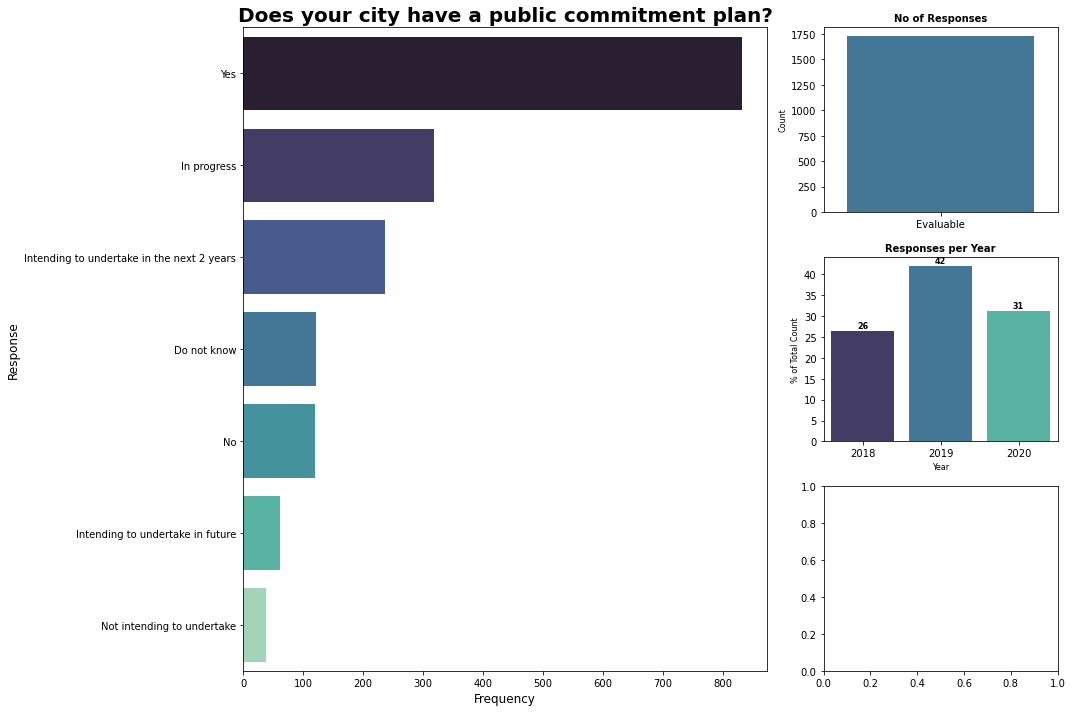

In [303]:
# select rows and get responses from dataframe
data = df3_2
answers = data.response_answer          

# provide corrosponding question context
print_question(df3_2, "3.2", columnnumber='1')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(15)                     # get top 15 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Does your city have a public commitment plan?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
#ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
plt.show();

**Commentary** 

It might make sense to investigate the commitment split by population bin. This follows the assumption that larger cities face more pressure and thus are more inclined to publicly commit to their emission targets. 


In [ ]:
map_commit = KeplerGl(height=600,
                      width=400)
map_commit.add_data(data=df3_2, name='commitment-map')
map_commit        

In [304]:
# rename response answer column in question-specific dataframe and map information to disclosure dataframe
cid_new = rename_and_merge(original_df=cid,
                           feature_df=df3_2,
                           feature="public_commitment")

In [306]:
cid_new

,type,theme,year,account_number,public,entity,country,region,population,city,lat,lon,public_commitment
0,cid,combined,2018,58671,public,Helsingør,Denmark,Europe,62686.0,Helsingør,56.034528,12.613613,Yes
1,cid,combined,2018,59167,public,Providencia,Chile,Latin America,126487.0,Providencia,-33.428838,-70.611337,Intending to undertake in future
2,cid,combined,2018,50553,public,Fresno,United States of America,North America,527438.0,Fresno,36.729529,-119.708861,Yes
3,cid,combined,2018,826407,public,Mirandela,Portugal,Europe,11852.0,Mirandela,41.489615,-7.177479,In progress
4,cid,combined,2018,60375,public,Archipiélago de San Andrés,Colombia,Latin America,120000.0,Archipiélago de San Andrés,12.380517,-81.614075,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,cid,combined,2020,35874,public,Phoenix,United States of America,North America,1615017.0,Phoenix,33.448437,-112.074142,Yes
2064,cid,combined,2020,42178,public,Quito,Ecuador,Latin America,2239191.0,Quito,-0.220164,-78.512327,Yes
2065,cid,combined,2020,848129,public,NaN,Honduras,Latin America,18308.0,Esquías,14.744453,-87.370397,Not intending to undertake
2066,cid,combined,2020,54632,public,Caruaru,Brazil,Latin America,314912.0,Caruaru,-8.282970,-35.972285,Intending to undertake in the next 2 years


## Why is there no public plan to address climate change? 

In [284]:
# create new dataframe around the question why there might be no public plan to address climate chanbge
# note that this information is not available in 2018
df3_2b = cir.query("(question_number == '3.2b' and year == 2020) or (question_number == '3.1b' and year == 2019)")

Question 3.2b:
'Please explain why there is no published plan that addresses climate change adaptation and outline any future arrangements you have to create a plan.'
------------------------------------------------------------------------------------------
1: 


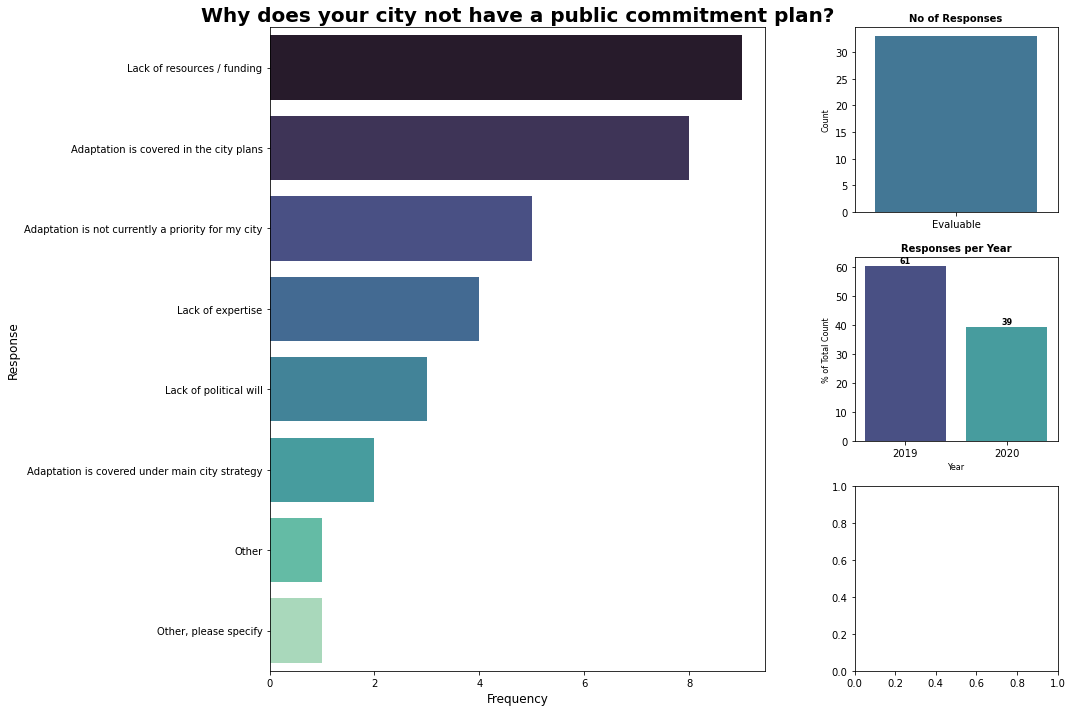

In [285]:
# select rows and get responses from dataframe
data = df3_2b.query("column_number == '1'")
answers = data.response_answer          

# provide corrosponding question context
print_question(df3_2b, "3.2b", columnnumber='1')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(15)                     # get top 15 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Why does your city not have a public commitment plan?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
#ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
plt.show();

**Commentary** 

While this information is interesting, we also see that there is a very limited amount of responses making this question difficult to evaluate. Hence, we will not dive into this topic any deeper. 

## Which frameworks are cities committing to? 

In [286]:
df3_3 = get_response_pivot(data=cir,
                           columnnumber='6',
                           questionnumber='3.3',
                           pivot=False,
                           add_info=True,
                           year=[2020])

Question 3.3:
'Please describe the main goals of your city’s adaptation efforts and the metrics / KPIs for each goal.'
------------------------------------------------------------------------------------------
6: 


Question 3.3:
'Please describe the main goals of your city’s adaptation efforts and the metrics / KPIs for each goal.'
------------------------------------------------------------------------------------------
6: 


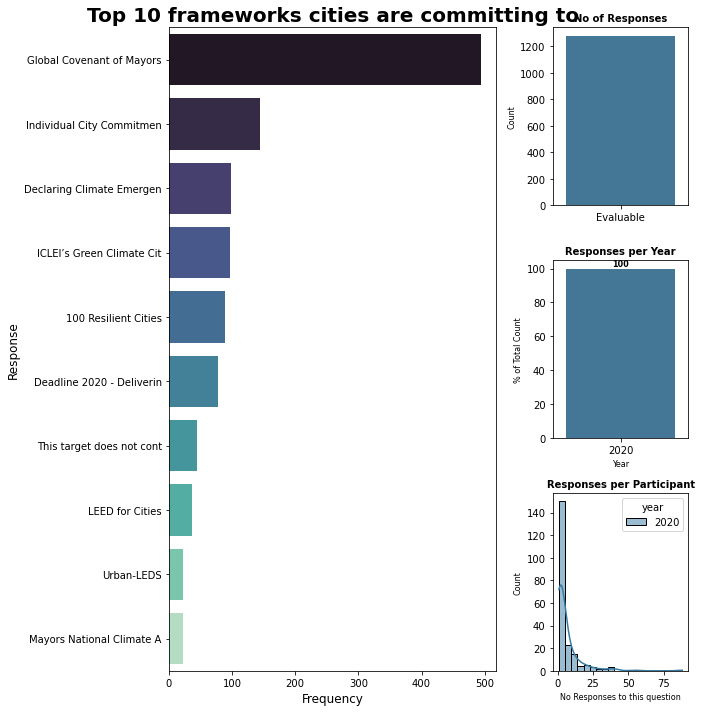

In [287]:
# select rows and get responses from dataframe
data = df3_3.query("column_number == '6'")
answers = data.response_answer          

# provide corrosponding question context
print_question(df3_3, "3.3", columnnumber='6')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Top 10 frameworks cities are committing to",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();


**Commentary** 

We see that there are a number of participants who gave more than 25 responses. Looking into the data it becomes evident that a number if cities have provided duplicate entries. We will remove them to avoid double counting. 

In [ ]:
df3_3_city=df3_3.query("column_number == 6")

In [ ]:
df3_3_city[df3_3_city.groupby("city")["response_answer"].transform(len)>1]["city"].value_counts()

In [65]:
df3_3_city = get_merge_df(data=df3_3, feature="city_framework")

## Corporates - Who is reported about their climate change actions? 

## Sustainability collaboration

### Cities - Are there partnerships with businesses in place? 

In [288]:
# create new dataframe, fetching only the information from the question whether a city is collaborating with businesses on climate action
# this information occurs in different question numbers for the different years
df6_2 = cir.query("(question_number == '6.2' and year == 2020) or (question_number == '6.1' and year == 2019) or (question_number == '5.1' and year == 2018)")

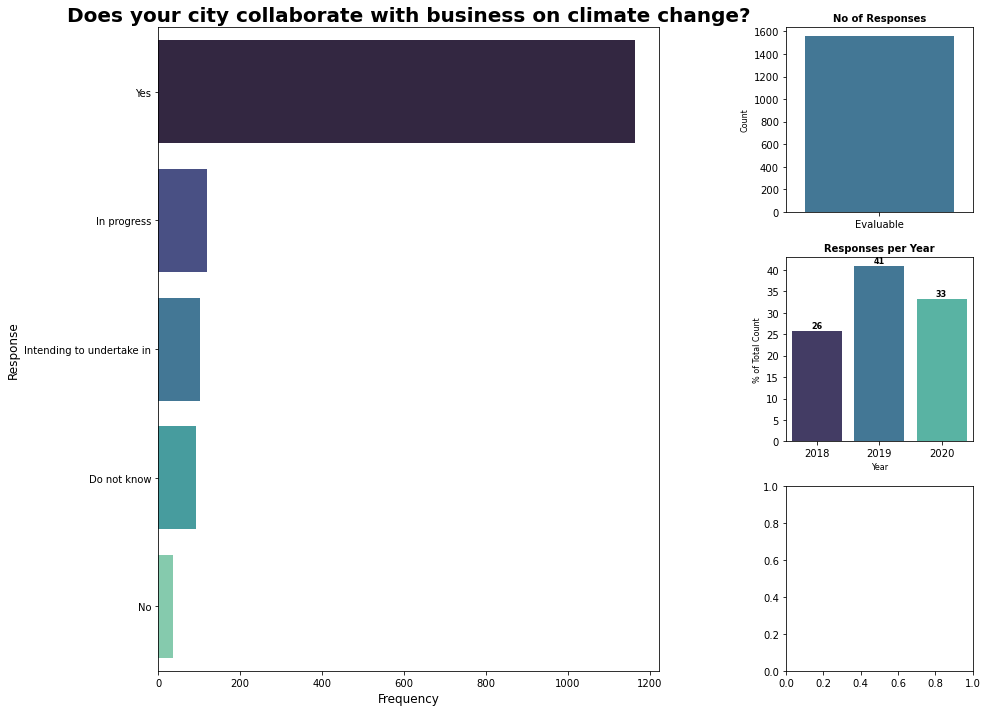

In [289]:
# select rows and get responses from dataframe
data = df6_2
answers = data.response_answer          
 

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(5)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Does your city collaborate with business on climate change?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
#ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

In [361]:
# rename response answer column in question-specific dataframe and map information to disclosure dataframe
cid_new = rename_and_merge(original_df=cid_new,
                 feature_df=df6_2,
                 feature="has_business_collaboration")

### In what areas do cities collaborate with businesses? 

In [309]:
# create new dataframe, fetching only the information from the question on what topics cities are collaborating with businesses
# this information occurs in different question numbers for the different years
df6_2a = cir.query("(question_number == '6.2a' and year == 2020 and column_number == 1) or (question_number == '6.1a' and year == 2019 and column_number == 1) or (question_number == '5.1a' and year == 2018 and column_number == 1)")

In [312]:
df6_2a.response_answer.value_counts()

Energy                                             628
Waste                                              351
Transport (Mobility)                               313
Building and Infrastructure                        234
Water                                              206
                                                  ... 
Other: Agriculture                                   1
Other: Clean Toronto Together                        1
Other: water conservation, energy use and waste      1
Other: Universities, consortium of project           1
Other: Water and Waste collection                    1
Name: response_answer, Length: 110, dtype: int64

In [317]:
# there is a long range of individual `Other` answers which will be grouped into a single other category
threshold_percent = 1
series = pd.value_counts(df6_2a['response_answer'])
mask = (series / series.sum() * 100).lt(threshold_percent)
df6_2a = df6_2a.assign(response_answer = np.where(df6_2a['response_answer'].isin(series[mask].index),'Other', df6_2a['response_answer']))

Question 6.2a:
'Please provide some key examples of how your city collaborates with business in the table below.'
------------------------------------------------------------------------------------------
1: 


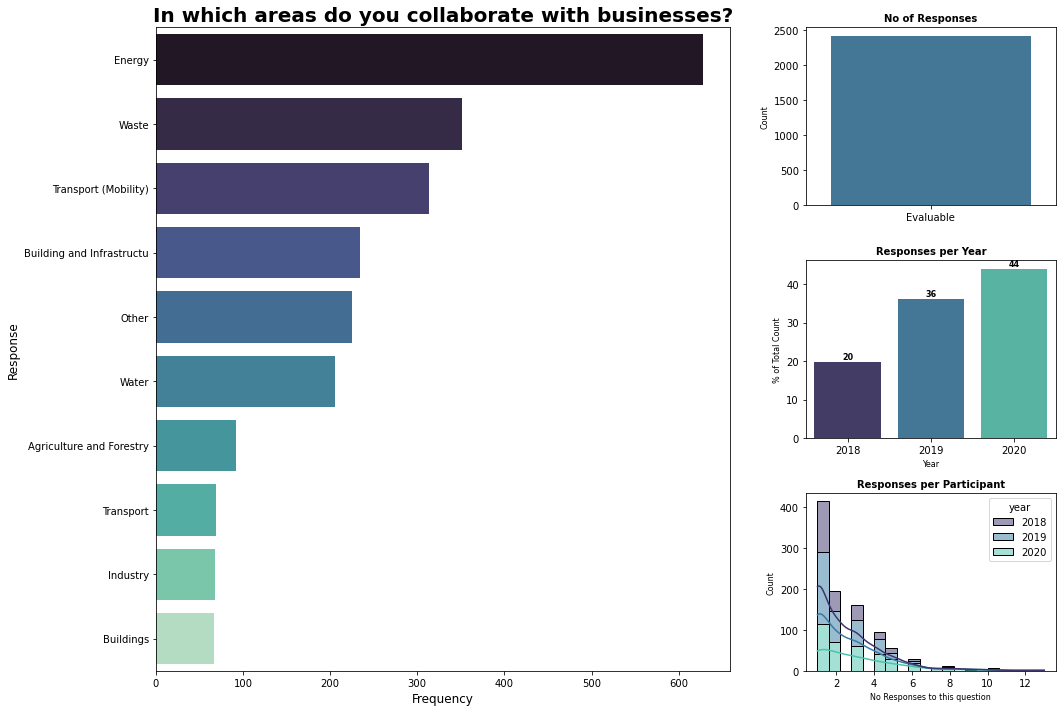

In [319]:
# select rows and get responses from dataframe
data = df6_2a
answers = data.response_answer          
 
# provide corrosponding question context
print_question(data, "6.2a", columnnumber='1')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="In which areas do you collaborate with businesses?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

In [359]:
# rename response answer column in question-specific dataframe and map information to disclosure dataframe
cid_new = rename_and_merge(original_df=cid_new,
                 feature_df=df6_2a,
                 feature="collaboration_area")

### What types of collaboration are in place? 

In [87]:
# this is a new question, which only appears in the 2020 questionnaire
df6_2a_2 = cir.query("question_number == '6.2a' and year == 2020")

Question 6.2a:
'Please provide some key examples of how your city collaborates with business in the table below.'
------------------------------------------------------------------------------------------
2: 


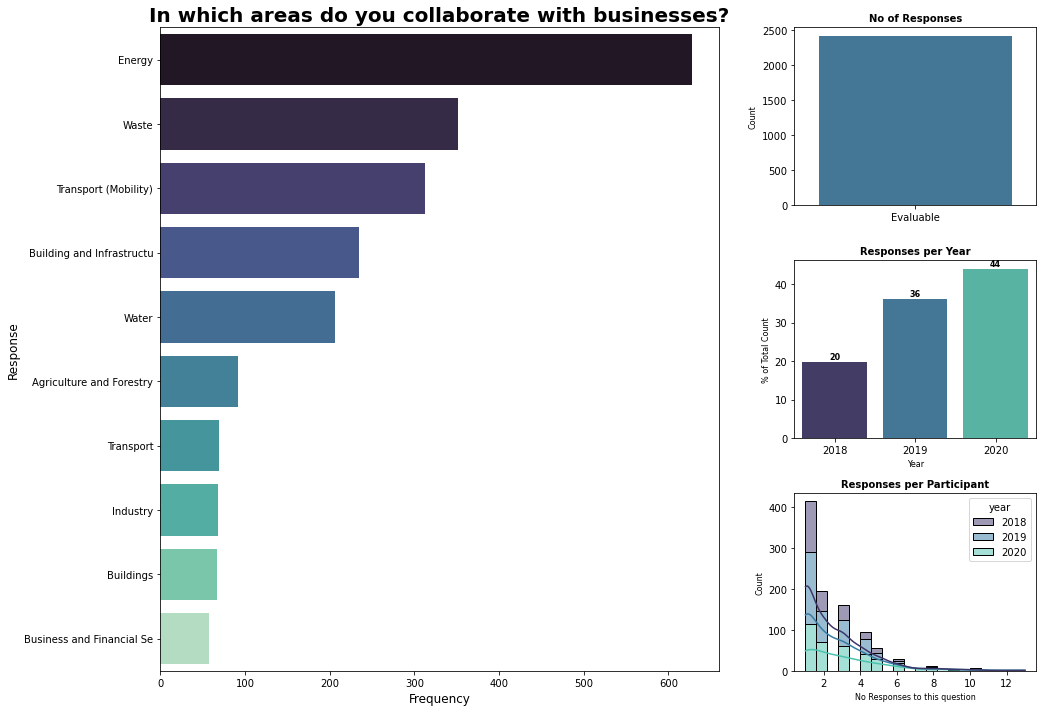

In [216]:
# select rows and get responses from dataframe
data = df6_2a
answers = data.response_answer          
 
# provide corrosponding question context
print_question(data, "6.2a", columnnumber='2')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values



# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="In which areas do you collaborate with businesses?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

### Analyzing the description of collaboration

In [80]:
df6_2 = cir.query("(question_number == '6.2a' and year == 2020 and column_number == 3) or (question_number == '6.1a' and year == 2019 and column_number == 3)")
text = df6_2.response_answer.values

In [ ]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 9),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [364]:
cid_map = KeplerGl(height = 600, width = 400)
cid_map.add_data(data=cid_new, name='disclosure_map')
cid_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'disclosure_map': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …

## Corporates - Do corporates have an integrated climate action plan? 

In [228]:
dfC12_1 = cor.query("question_number == 'C12.1'")

Question C12.1:
'Do you engage with your value chain on climate-related issues?'
------------------------------------------------------------------------------------------
a: 
l: 
l: 


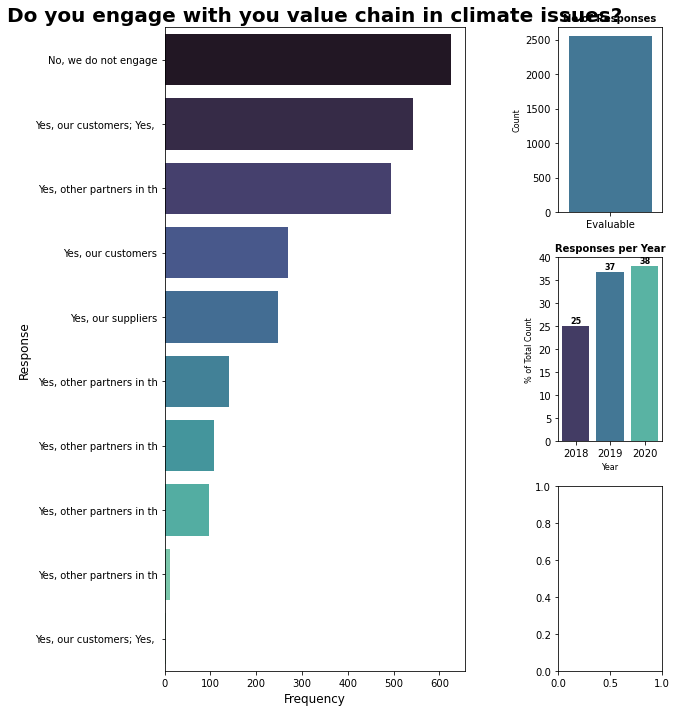

In [229]:
# select rows and get responses from dataframe
data = dfC12_1
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.1", columnnumber='all')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(cor.query("question_number == 'C12.1'")["response_answer"])
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Do you engage with you value chain in climate issues?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
#ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

**Commentary** 

We see that multiple answers from corporates are combined through a semicolon which impedes the interpretability of the graph. Consequenty, we will need to split the combined answers into their individual components. 

In [264]:
# we deploy a function that splits the combined responses into its individual components and explodes them into the same column
# this function was taken from stakeovervflow
def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df


In [265]:
dfC12_1 = tidy_split(df=dfC12_1, column="response_answer", sep=";") 

Question C12.1:
'Do you engage with your value chain on climate-related issues?'
------------------------------------------------------------------------------------------
a: 
l: 
l: 


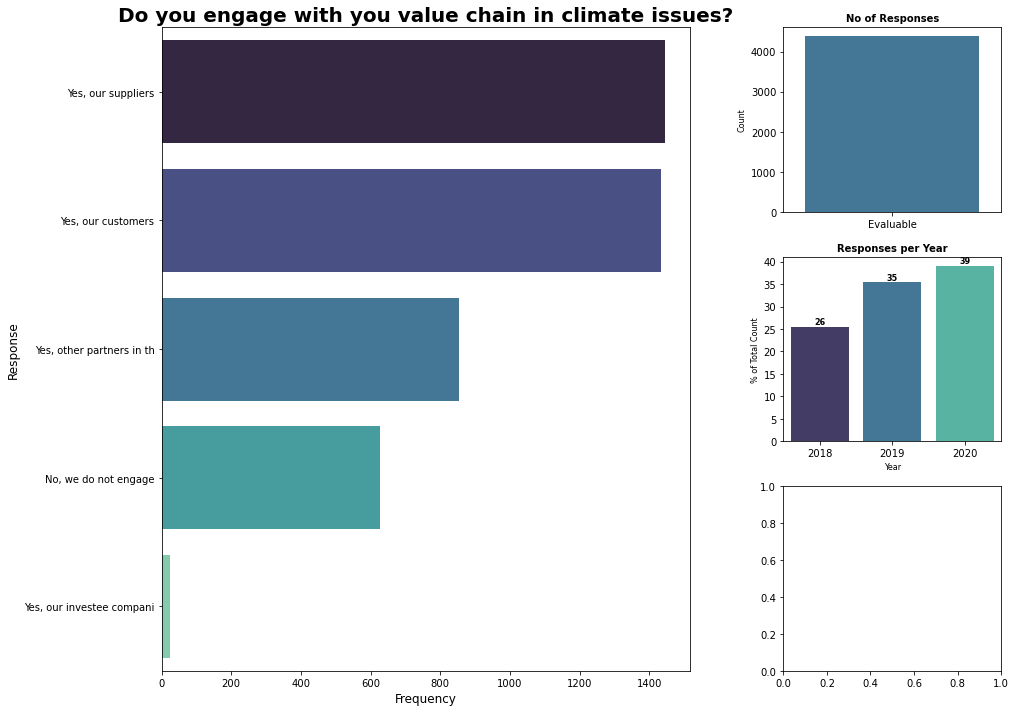

In [271]:
# select rows and get responses from dataframe
data = dfC12_1
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.1", columnnumber='all')     

# preprocess / calculate data for visualization
# we strip the left whitespaces from the response answer column
val, perc = get_pct_freq(answers.str.lstrip())
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Do you engage with you value chain in climate issues?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
#ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

**Commentary** 

Cleaning the columns has changed the results quite significantly. We see that the majority of participating corporates report that they already collaborate with suppliers of their value chain. Interestingly, there are less companies with collaboration from the customer side. 

In [299]:
# rename response answer column in question-specific dataframe and map information to disclosure dataframe
cod_new = rename_and_merge(original_df=cod,
                           feature_df=dfC12_1,
                           feature="value_chain_engagement")

In [296]:
def rename_and_merge(original_df, feature_df, feature, left_on=None, right_on=None, how='left'):

    '''this function helps to quickly rename the new feature column and to merge it to the original disclosure dataframe, drop duplicates as well as the key_0 column
    original_df: disclosure dataframe that the feature is mapped onto
    feature: information that is supposed to be added to the original df. Needs to be passed on as a list.
    feature_df: dataframe with the information that is supposed to be added to the original df
    left_on: information used for mapping the data. Default set to 'select_key'
    right_on: information from feature df used for mapping. Default set to 'select_key'
    how: default set to left'''

    #create unique select key from year and account number in feature dataframe
    feature_df["select_key"] = feature_df.year.astype(str)+"_"+feature_df.account_number.astype(str)
    original_df["select_key"] = original_df.year.astype(str)+"_"+original_df.account_number.astype(str)

    # rename response answer to the new feature in feature df
    feature_df[feature] = feature_df["response_answer"]

    # merge feature column to disclosure dataframe
    if left_on is None:
        left_on = original_df["select_key"]
    
    if right_on is None:
        right_on = feature_df["select_key"]
    

    original_df = pd.merge(left=original_df,
                          right=feature_df[feature],
                          left_on=left_on,
                          right_on=right_on,
                          how=how)
    original_df.drop_duplicates(inplace=True)
    original_df.drop("key_0", axis=1, inplace=True)
    original_df.drop("select_key", axis=1, inplace=True)
    return original_df

In [297]:
dfC12_1a = get_response_pivot(data=cor,
                          questionnumber='C12.1a',
                          columnnumber='all',
                          pivot=False,
                          add_info=False,
                          year=[2018, 2019, 2020])

Question C12.1a:
'Provide details of your climate-related supplier engagement strategy.'
------------------------------------------------------------------------------------------
1.0: 'C12.1a_c1-Type of engagement'
2.0: 'C12.1a_c2-Details of engagement'
3.0: 'C12.1a_c3-% of suppliers by number'
4.0: 'C12.1a_c4-% total procurement spend (direct and indirect)'
5.0: 'C12.1a_c5-% Scope 3 emissions as reported in C6.5'
 'C12.1a_c5-% of supplier-related Scope 3 emissions as reported in C6.5'
6.0: 'C12.1a_c6-Rationale for the coverage of your engagement'
7.0: 'C12.1a_c7-Impact of engagement, including measures of success'
8.0: 'C12.1a_c8-Comment'


In [105]:
dfC12_1a.head()

,account_number,row_number,row_name,question_number,question_name,column_number,column_name,response_answer,year,entity,Key
140245,58,1,NaN,C12.1a,Provide details of your climate-related suppli...,1.0,C12.1a_c1-Type of engagement,Information collection (understanding supplier...,2018,ABM INDUSTRIES INC,0
768295,58,2,NaN,C12.1a,Provide details of your climate-related suppli...,1.0,C12.1a_c1-Type of engagement,Information collection (understanding supplier...,2020,ABM INDUSTRIES INC,1
768402,58,1,NaN,C12.1a,Provide details of your climate-related suppli...,1.0,C12.1a_c1-Type of engagement,Compliance & onboarding,2020,ABM INDUSTRIES INC,2
1284462,58,1,NaN,C12.1a,Provide details of your climate-related suppli...,1.0,C12.1a_c1-Type of engagement,Compliance & onboarding,2019,ABM INDUSTRIES INC,3
271242,64,1,NaN,C12.1a,Provide details of your climate-related suppli...,1.0,C12.1a_c1-Type of engagement,Information collection (understanding supplier...,2018,Abbott Laboratories,4


Question C12.1a:
'Provide details of your climate-related supplier engagement strategy.'
------------------------------------------------------------------------------------------
1: 


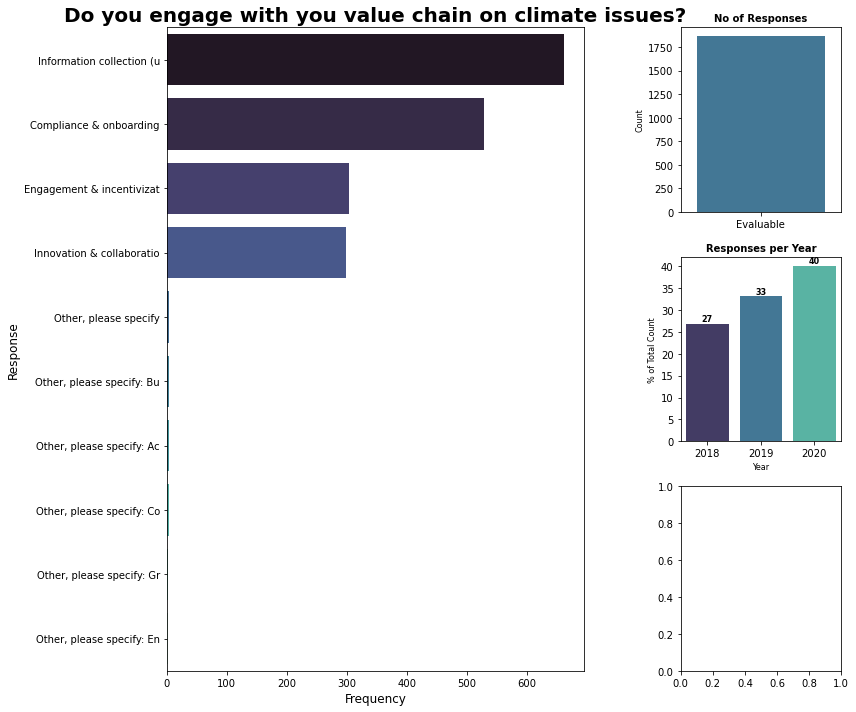

In [108]:
# select rows and get responses from dataframe
data = dfC12_1a.query("column_number == '1'")
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.1a", columnnumber='1')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="How do you engage with you supply chain on climate issues?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
#ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

As we can see, the vast majority of corporates engage with their suppliers in an information collection as well as compliance & onboarding basis. In contrast, co-creating on climate-related issues with their suppliers via innovation & collaboration is less common. 

In addition, we denote that a number of other categories have been specified. Since these are difficult to evaluate, we group them together into a combined **Other** response. 

In [109]:
# replace all of the individual "other" specifications into a single "other" group
x = dfC12_1a.query("column_number == '1'")
dfC12_1a_grouped = x.replace(x.groupby('response_answer').sum().index[4:], 'Other')

Question C12.1a:
'Provide details of your climate-related supplier engagement strategy.'
------------------------------------------------------------------------------------------
1: 


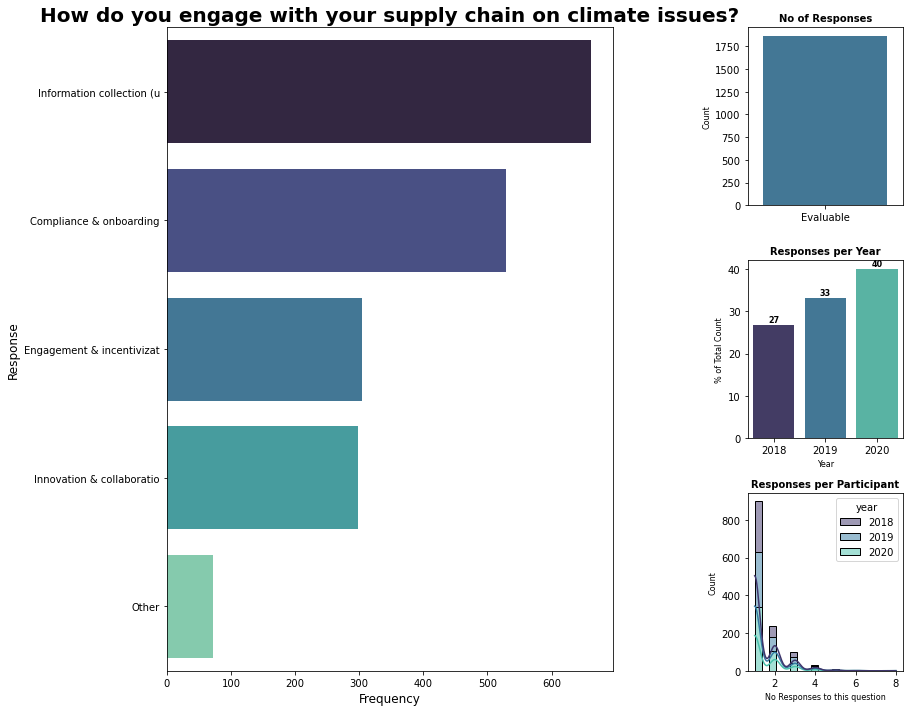

In [321]:
# select rows and get responses from dataframe
data = dfC12_1a_grouped.query("column_number == '1'")
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.1a", columnnumber='1')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="How do you engage with your supply chain on climate issues?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

Grouping the remaining answers into a single **Other** group helps to understand its frequency in relation to the preset answers. We see that the order of importance is not changed.  

In [347]:
cod_new = rename_and_merge(original_df=cod_new,
                 feature_df=dfC12_1a_grouped,
                 feature="supply_chain_engagement")

### What is the percentage of suppliers that corporates engage with? 

Question C12.1a:
'Provide details of your climate-related supplier engagement strategy.'
------------------------------------------------------------------------------------------
3: 


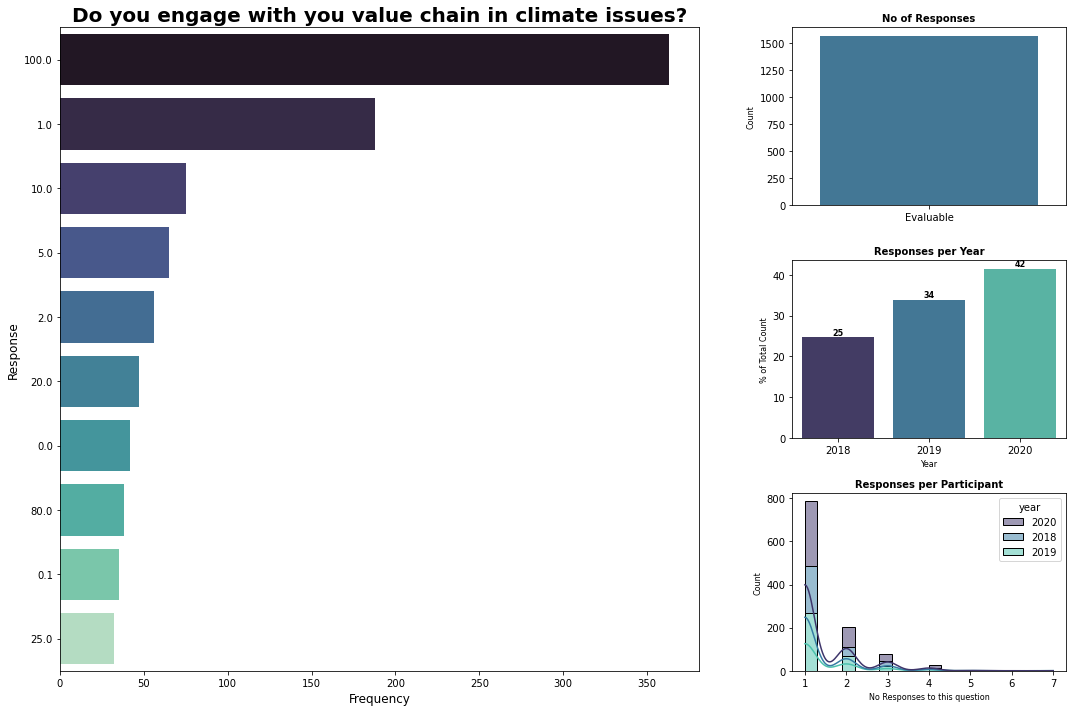

In [323]:
# select rows and get responses from dataframe
data = dfC12_1a.query("column_number == '3'")
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.1a", columnnumber='3')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Do you engage with you value chain in climate issues?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

**Commentary** 

While the information itself is interesting, it appears that some of the information provided is rather random and difficult to verify. Consequently, we will omit this question number in the further analysis. 

### How do corporates engage with their customers?

In [400]:
dfC12_1b = get_response_pivot(data=cor,
                          questionnumber='C12.1b',
                          columnnumber='all',
                          pivot=False,
                          add_info=False,
                          year=[2018, 2019, 2020])

Question C12.1b:
'Give details of your climate-related engagement strategy with your customers.'
------------------------------------------------------------------------------------------
1.0: 'C12.1b_c1-Type of engagement'
2.0: 'C12.1b_c2-Details of engagement'
3.0: 'C12.1b_c3-Size of engagement' 'C12.1b_c3-% of customers by number'
4.0: 'C12.1b_c4-% Scope 3 emissions as reported in C6.5'
 'C12.1b_c4-% of customer - related Scope 3 emissions as reported in C6.5'
5.0: 'C12.1b_c5-Please explain the rationale for selecting this group of customers and scope of engagement'
6.0: 'C12.1b_c6-Impact of engagement, including measures of success'
 'C12.1b_c6-Please explain the rationale for selecting this group of customers and scope of engagement'
7.0: 'C12.1b_c7-Impact of engagement, including measures of success'


We again group all **other, please specify** responses into a single **Other** group

In [325]:
# replace all of the individual "other" specifications into a single "other" group
x = dfC12_1b.query("column_number == '1'")
dfC12_1b_grouped = x.replace(x.groupby('response_answer').sum().index[4:], 'Other')

Question C12.1b:
'Give details of your climate-related engagement strategy with your customers.'
------------------------------------------------------------------------------------------
1: 


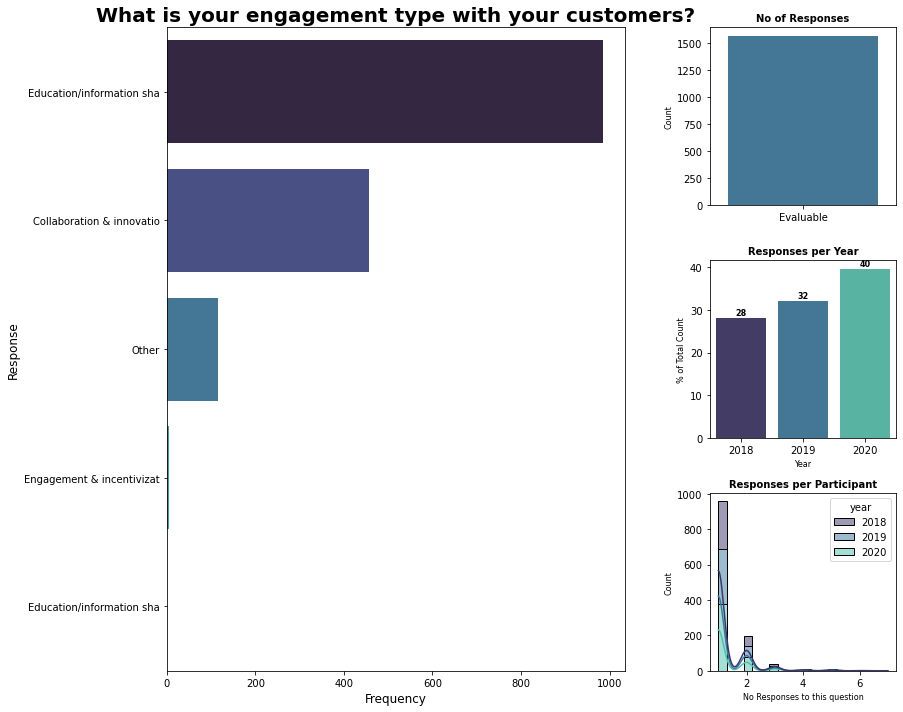

In [326]:
# select rows and get responses from dataframe
data = dfC12_1b_grouped.query("column_number == '1'")
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.1b", columnnumber='1')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="What is your engagement type with your customers?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

### With how many of your customers do you engage? 

In [345]:
cod_new = rename_and_merge(original_df=cod_new,
                 feature_df=dfC12_1b_grouped,
                 feature="customer_engagement")

,type,theme,year,account_number,public,entity,country,addressed_by,minimum_tier,selected_tier,...,activities,sectors,industries,primary_activity,primary_sector,primary_industry,primary_questionnaire_sector,value_chain_engagement,customer_engagement_x,customer_engagement_y
0,cod,water,2019,20111,public,Vander Bend,United States of America,NaN,Water - Full,Water - Minimum,...,Fabricated metal components,Metal products manufacturing,Manufacturing,Fabricated metal components,Metal products manufacturing,Manufacturing,General,"No, we do not engage",NaN,NaN
1,cod,water,2019,35800,public,Bel Fuse Inc.,United States of America,Self selected companies water,Water - Full,Water - Minimum,...,Fabricated metal components,Metal products manufacturing,Manufacturing,Fabricated metal components,Metal products manufacturing,Manufacturing,General,"Yes, our customers",NaN,NaN
2,cod,water,2019,35800,public,Bel Fuse Inc.,United States of America,Self selected companies water,Water - Full,Water - Minimum,...,Fabricated metal components,Metal products manufacturing,Manufacturing,Fabricated metal components,Metal products manufacturing,Manufacturing,General,"Yes, our suppliers",NaN,NaN
3,cod,water,2019,32533,public,"Integrated Device Technology, Inc.",United States of America,Self selected companies water,Water - Minimum,Water - Full,...,Electronic components,Electrical & electronic equipment,Manufacturing,Electronic components,Electrical & electronic equipment,Manufacturing,General,"Yes, our suppliers",NaN,NaN
4,cod,water,2019,59905,public,Darling Ingredients Inc,United States of America,Self selected companies water,Water - Minimum,Water - Full,...,"Animal processing, Other food processing",Food & beverage processing,"Food, beverage & agriculture",Animal processing,Food & beverage processing,"Food, beverage & agriculture","Food, beverage & tobacco","Yes, our customers",Education/information sharing,Education/information sharing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8322,cod,climate,2019,23576,public,Sonoco Products Company,United States of America,"CCGR1800, Continuity Climate Change, Environm...",Climate Change - Full,Climate Change - Full,...,"Other containers & packaging, Paper packaging...","Light manufacturing, Paper products & packagi...",Manufacturing,Plastic products,Plastic product manufacturing,Manufacturing,General,"Yes, our customers",Education/information sharing,Education/information sharing
8323,cod,climate,2019,23576,public,Sonoco Products Company,United States of America,"CCGR1800, Continuity Climate Change, Environm...",Climate Change - Full,Climate Change - Full,...,"Other containers & packaging, Paper packaging...","Light manufacturing, Paper products & packagi...",Manufacturing,Plastic products,Plastic product manufacturing,Manufacturing,General,"Yes, our suppliers",Other,Other
8324,cod,climate,2019,23576,public,Sonoco Products Company,United States of America,"CCGR1800, Continuity Climate Change, Environm...",Climate Change - Full,Climate Change - Full,...,"Other containers & packaging, Paper packaging...","Light manufacturing, Paper products & packagi...",Manufacturing,Plastic products,Plastic product manufacturing,Manufacturing,General,"Yes, our suppliers",Other,Education/information sharing
8325,cod,climate,2019,23576,public,Sonoco Products Company,United States of America,"CCGR1800, Continuity Climate Change, Environm...",Climate Change - Full,Climate Change - Full,...,"Other containers & packaging, Paper packaging...","Light manufacturing, Paper products & packagi...",Manufacturing,Plastic products,Plastic product manufacturing,Manufacturing,General,"Yes, our suppliers",Education/information sharing,Other


Question C12.1b:
'Give details of your climate-related engagement strategy with your customers.'
------------------------------------------------------------------------------------------
3: 


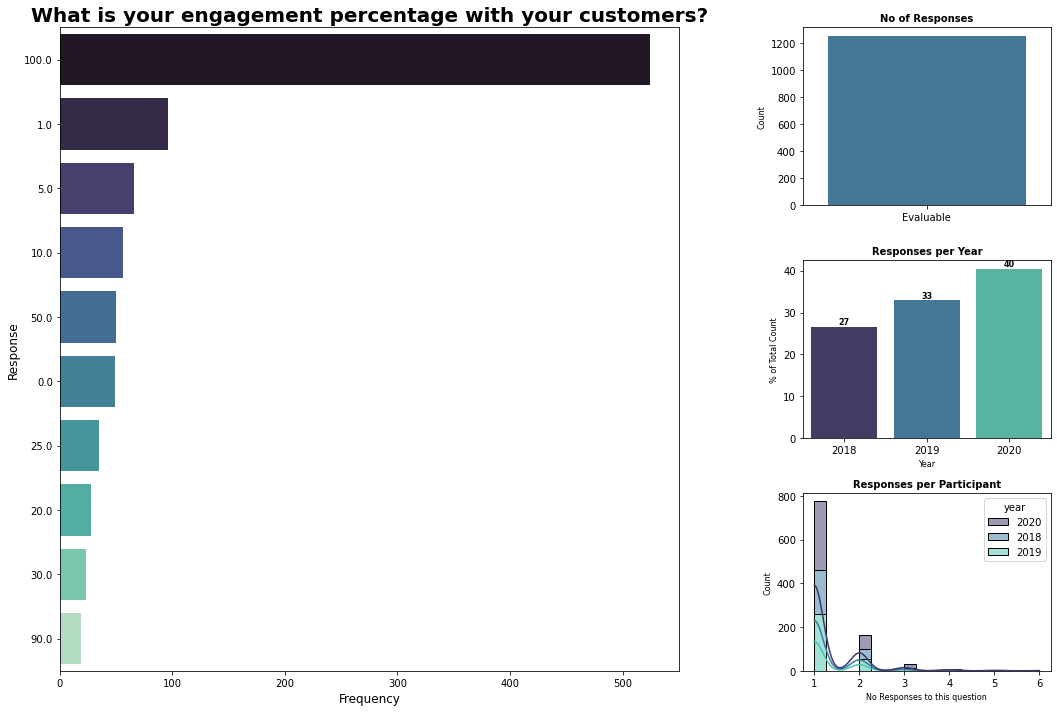

In [333]:
# select rows and get responses from dataframe
data = dfC12_1b.query("column_number == '3'")
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.1b", columnnumber='3')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="What is your engagement percentage with your customers?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

**Commentary** 

Again, the engagement percentage with customers appears to be rather random and is difficult to verify. We will omitt this in the further analysis.

### Wordcloud - What are companies saying about their customer engagement?

In [ ]:
dfC12_1b_7 = cor.query("question_number == 'C12.1b' and column_number == 6")
text = dfC12_1b_7.response_answer.values

In [ ]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (12, 9),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Corporate engagement with policy makers

As a next step, we will examine whether corporates not only engage with suppliers and customers but also with policy makers. This information is vital in determining ways of collaboration between corporates and cities. 
For that we start be scrutinizing question `C12.3` which captures in which forms cooperating efforts exists if there are any at all. 

In [334]:
dfC12_3 = cor.query("question_number == 'C12.3'")

Question C12.3:
'Do you engage in activities that could either directly or indirectly influence public policy on climate-related issues through any of the following?'
------------------------------------------------------------------------------------------
a: 
l: 
l: 


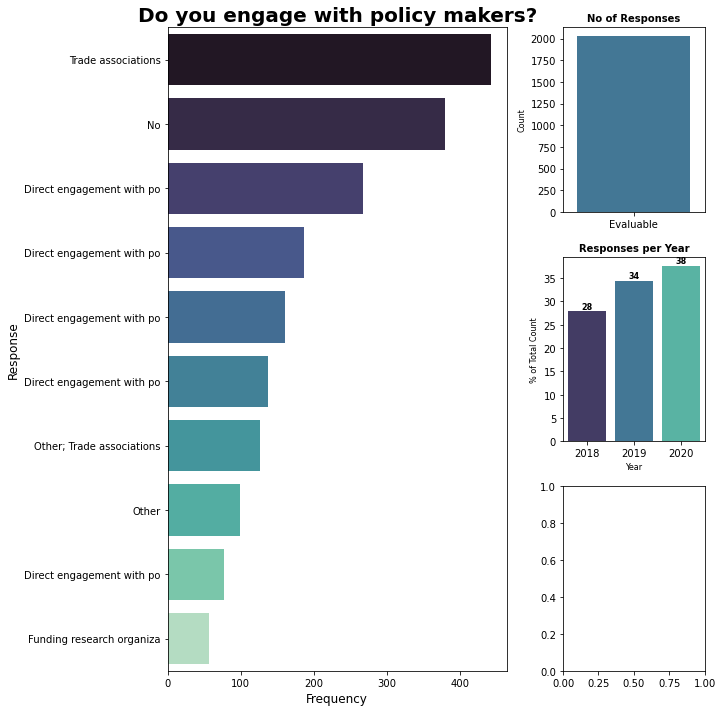

In [337]:
# select rows and get responses from dataframe
data = cor.query("question_number == 'C12.3'")
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.3", columnnumber='all')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Do you engage with policy makers?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
#ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

Similar to previous questions, we see that multiple answer combinations are split into separate responds columns. We will split the columns and assign them to their respective answer. 

In [135]:
cor.query("question_number == 'C12.3'")["response_answer"].unique()

array(['Direct engagement with policy makers; Trade associations',
       'Funding research organizations; Other; Trade associations',
       'Trade associations',
       'Direct engagement with policy makers; Other; Trade associations',
       'Direct engagement with policy makers; Other',
       'Direct engagement with policy makers; Funding research organizations; Trade associations',
       'Other; Trade associations',
       'Funding research organizations; Trade associations',
       'Direct engagement with policy makers',
       'Funding research organizations; Other',
       'Direct engagement with policy makers; Funding research organizations; Other; Trade associations',
       'No',
       'Direct engagement with policy makers; Funding research organizations',
       'Other',
       'Direct engagement with policy makers; Funding research organizations; Other',
       'Funding research organizations', 'No; Other; Trade associations',
       'No; Trade associations'], dtype=obj

In [338]:
dfC12_3 = tidy_split(df=dfC12_3, column="response_answer", sep=";") 

Question C12.3:
'Do you engage in activities that could either directly or indirectly influence public policy on climate-related issues through any of the following?'
------------------------------------------------------------------------------------------
a: 
l: 
l: 


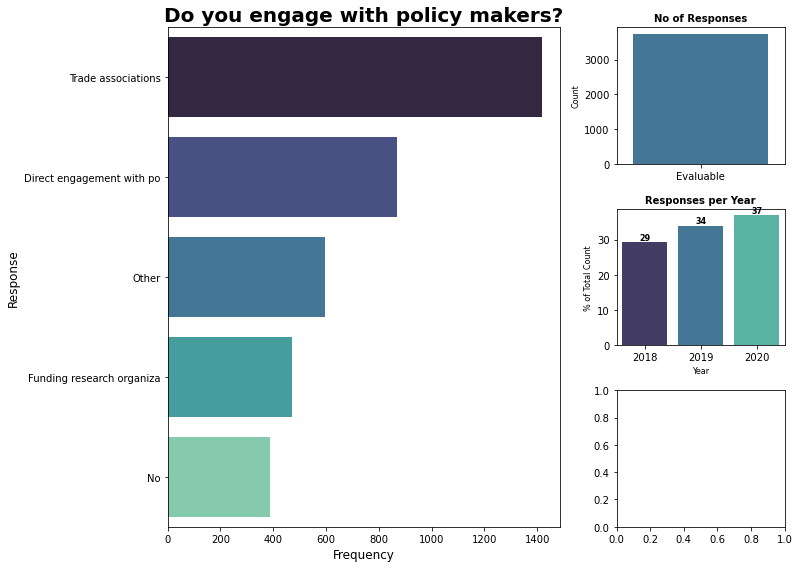

In [339]:
# select rows and get responses from dataframe
data = dfC12_3
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.3", columnnumber='all')    

# preprocess / calculate data for visualization
# we remove the whitespaces at the beginning of the 
val, perc = get_pct_freq(answers.str.lstrip())
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(12,8), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Do you engage with policy makers?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
#ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

In [350]:
cod_new = rename_and_merge(original_df=cod_new,
                 feature_df=dfC12_3,
                 feature="policy_engagement")

### On what topics are corporates engaging with policy makers? 

In [385]:
dfC12_3a = cor.query("question_number == 'C12.3a' and column_number == '1'")

In [386]:
# the response answer column has more than 200 different entries, most of which occur only once.
#  We will group all entries which account for less than 2% of all responses into the category `Other`
threshold_count = 2
series = pd.value_counts(dfC12_3a['response_answer'])
mask = (series / series.sum() * 100).lt(threshold_count)
dfC12_3a = dfC12_3a.assign(response_answer = np.where(dfC12_3a['response_answer'].isin(series[mask].index),'Other', dfC12_3a['response_answer']))

Question C12.3a:
'On what issues have you been engaging directly with policy makers?'
------------------------------------------------------------------------------------------
1: 


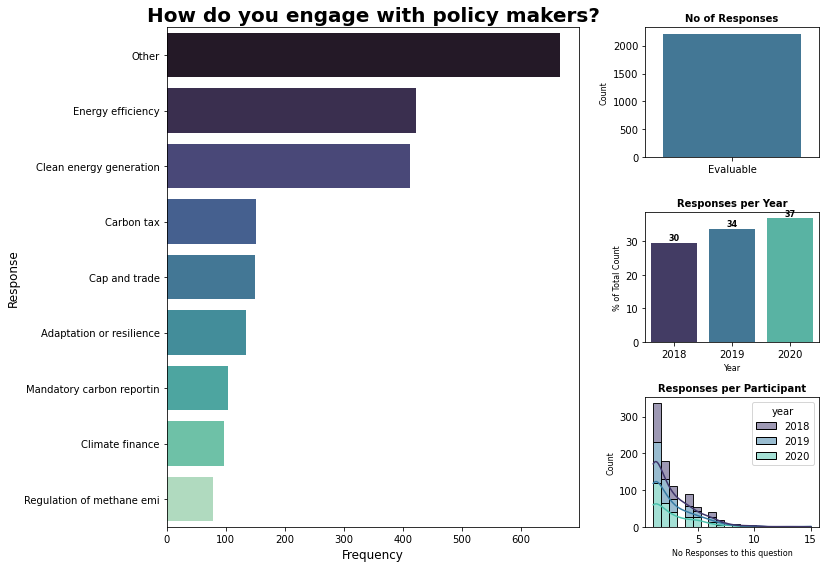

In [388]:
data = dfC12_3a
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.3a", columnnumber='1')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(12,8), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="How do you engage with policy makers?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

In [389]:
cod_new = rename_and_merge(original_df=cod_new,
                           feature_df=dfC12_3,
                           feature="policy_engagement_type")

### Is the corporates view aligned with the policy makers? 

In [392]:
dfC12_3a_2 = cor.query("question_number == 'C12.3a' and column_number == '2'")

Question C12.3a:
'On what issues have you been engaging directly with policy makers?'
------------------------------------------------------------------------------------------
2: 


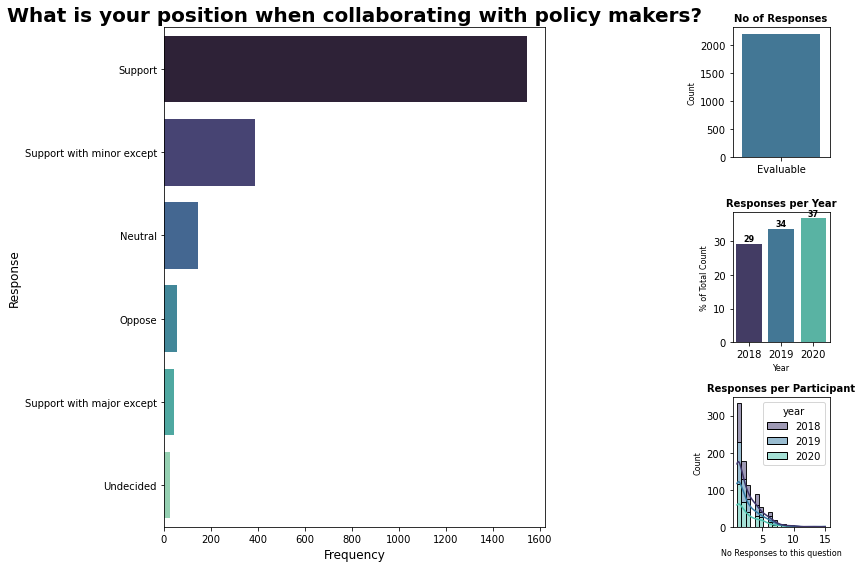

In [393]:
data = dfC12_3a_2
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.3a", columnnumber='2')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(12,8), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="What is your position when collaborating with policy makers?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

### What is the engagement about? 

In [ ]:
dfC12_3a = cor.query("question_number == 'C12.3a' and column_number == 4")
text = dfC12_3a.response_answer.values

In [ ]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (9, 6),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Internal carbon pricing

In [405]:
dfC11_3 = get_response_pivot(data=cor,
                          questionnumber='C11.3',
                          columnnumber='all',
                          pivot=False,
                          add_info=False,
                          year=[2018, 2019, 2020])

Question C11.3:

------------------------------------------------------------------------------------------


# Functions 

As a next step, we would like to add these findings as a form of feature engineering to the city and corporate disclosure dataframe. Let's beginn with the `cities`.

First, we build a function that helps to make this process a little faster. 

In [12]:
def get_merge_df(data, feature, information=None):
    '''this function helps to convert the responses from the get_response_pivot function into a dataframe that can later on be mapped to the          disclosure data as a form of feature engineering
    data: dataframe from which the information is extracted
    feature: information that is to be added to the dataframe
    information: columns added to the helper dataframe'''

    if information is None:
        information = data[["account_number", "year", "response_answer"]]
    
    data[feature] = data["response_answer"]
    data.drop("response_answer", axis=1, inplace=True)
    return data


In [139]:
def merge_feature(original_df, feature_df, features, on=None, how='left'):
    '''this function helps to quickly merge new features to the original disclosure dataframe, drops duplicates as well as the key_0 column
    original_df: disclosure dataframe that the feature is mapped onto
    features: information that is supposed to be added to the original df. Needs to be passed on as a list.
    feature_df: dataframe with the information that is supposed to be added to the original df
    left_on: information used for mapping the data. Default set to 'account_number'
    right_on: information from feature df used for mapping. Default set to 'account_number'
    how: default set to left'''

    if on is None:
        on = ("year", "account_number")


    original_df = pd.merge(left=original_df,
                          right=feature_df[features],
                          on=on,
                          how=how)
    original_df.drop_duplicates(inplace=True)
    original_df.drop("key_0", axis=1, inplace=True)
    return original_df


# Test Zone: K-Means Clustering

## Open Text Questions for Collaboration between Cities and Corporates

### Describe your cities' collaboration with businesses

In [409]:
print("number of responses:", cir.query("question_number == '6.2a' and column_number == '3'")["response_answer"].count())
print_question(data=cir,
               questionnumber='6.2a',
               columnnumber='3')

number of responses: 1066
Question 6.2a:
'Please provide some key examples of how your city collaborates with business in the table below.'
------------------------------------------------------------------------------------------
3: 


In [411]:
test = get_response_pivot(data=cir,
                          questionnumber='6.2a',
                          columnnumber='3',
                          pivot=False,
                          add_info=True,
                          year=[2018, 2019, 2020])

Question 6.2a:
'Please provide some key examples of how your city collaborates with business in the table below.'
------------------------------------------------------------------------------------------
3: 


**Main Idea**

The main idea for the following analysis is to compare how both cities and corporates view and describe their collaborative efforts.  
Here, we pursue the objective to find patterns and insights of where this collaboration can be extended as well as areas where partnerships are already working rather well.  

For this analysis, we will be using the natural language processing models of `Spacy`. 


### Text pre-processing

### Remove Stop words

In [509]:
# Import english stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
test['response_without_stopwords'] = test['response_answer'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [510]:
#remove spanish stop words
stop = stopwords.words('spanish')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
test['response_without_stopwords'] = test['response_answer'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#### 1. TF-IDF

In [511]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [512]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(test["response_without_stopwords"])
vectors_norm = normalize(vectors)
vectors_array = vectors_norm.toarray()
feature_names = vectorizer.get_feature_names()

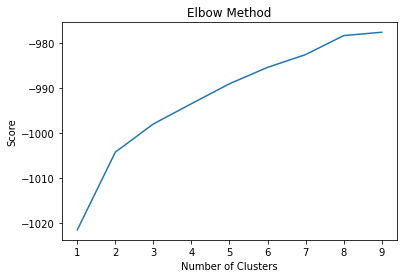

In [513]:
num_clusters = range(1,10)

km = [KMeans(n_clusters=i) for i in num_clusters]
score = [km[i].fit(vectors).score(vectors) for i in range(len(km))]

plt.plot(num_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

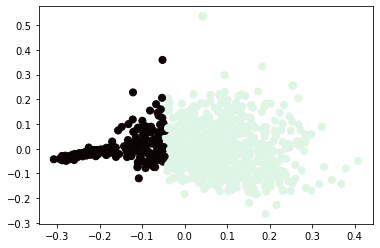

In [514]:
sklearn_pca = PCA(n_components=2)
vectors = sklearn_pca.fit_transform(vectors_array)

test_km = KMeans(2,'k-means++', 1000)
fitted = test_km.fit(vectors)
predicted_values = test_km.predict(vectors)

# plot the results in a scatterplot
plt.scatter(vectors[:,0], vectors[:,1], c=predicted_values, s=50, cmap="mako")

In [515]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(vectors_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array=vectors, prediction=predicted_values, n_feats=10)

In [516]:
dfs

[   features     score
 0        do  0.025760
 1        da  0.024127
 2  empresas  0.023587
 3       com  0.023331
 4        em  0.019771
 5        et  0.016043
 6       des  0.014331
 7       and  0.012511
 8      with  0.012188
 9  programa  0.011803,
   features     score
 0      the  0.138425
 1      and  0.099638
 2       to  0.080322
 3       of  0.077231
 4       in  0.059987
 5     city  0.050713
 6   energy  0.048370
 7     with  0.045124
 8      for  0.040176
 9       is  0.034555]

### Describe your company's collaboration with policy makers

In [451]:
print("number of responses:", cor.query("question_number == 'C12.3a' and column_number == '3'")["response_answer"].count())

test_corp = get_response_pivot(data=cor,
                               questionnumber="C12.3a",
                               columnnumber='3',
                               pivot=False,
                               add_info=False,
                               year=[2018, 2019, 2020])

number of responses: 2208
Question C12.3a:
'On what issues have you been engaging directly with policy makers?'
------------------------------------------------------------------------------------------
3: 


In [517]:
# Import english stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
test_corp['response_without_stopwords'] = test_corp['response_answer'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#remove spanish stop words
stop = stopwords.words('spanish')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
test_corp['response_without_stopwords'] = test_corp['response_answer'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [518]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(test_corp["response_without_stopwords"])
vectors_norm = normalize(vectors)
vectors_array = vectors_norm.toarray()
feature_names = vectorizer.get_feature_names()

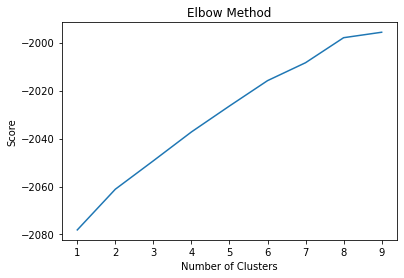

In [520]:
num_clusters = range(1,10)

km = [KMeans(n_clusters=i) for i in num_clusters]
score = [km[i].fit(vectors).score(vectors) for i in range(len(km))]

plt.plot(num_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

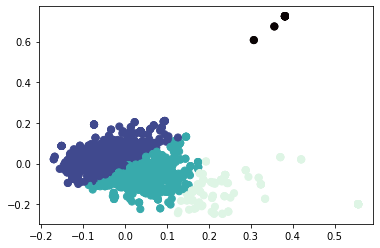

In [521]:
sklearn_pca = PCA(n_components=2)
vectors = sklearn_pca.fit_transform(vectors_array)

test_km = KMeans(4,'k-means++', 1000)
fitted = test_km.fit(vectors)
predicted_values = test_km.predict(vectors)

# plot the results in a scatterplot
plt.scatter(vectors[:,0], vectors[:,1], c=predicted_values, s=50, cmap="mako")

In [522]:
dfs = get_top_features_cluster(tf_idf_array=vectors, prediction=predicted_values, n_feats=10)
dfs

[   features     score
 0  proposed  0.301996
 1  neutralâ  0.236123
 2    chosen  0.234317
 3  decision  0.222110
 4   details  0.220804
 5   depends  0.217921
 6        on  0.212840
 7   letters  0.204906
 8   because  0.202333
 9       any  0.200701,
   features     score
 0      the  0.091595
 1      and  0.073059
 2       to  0.058954
 3       of  0.057613
 4       in  0.053218
 5  climate  0.036753
 6       on  0.036560
 7     with  0.036247
 8      for  0.036110
 9   carbon  0.027086,
     features     score
 0     energy  0.102504
 1        the  0.102177
 2        and  0.100367
 3         of  0.073481
 4         to  0.072536
 5         in  0.059433
 6  renewable  0.041110
 7       with  0.037988
 8        for  0.036626
 9         as  0.035196,
      features     score
 0      energy  0.223144
 1         and  0.144311
 2  efficiency  0.117314
 3         the  0.092093
 4      policy  0.083256
 5          as  0.078593
 6    strategy  0.075136
 7        have  0.073763
 8          w

In [14]:
def print_question(data, questionnumber, columnnumber):
    """Print unique column / question combination"""
    
    print(f'Question {questionnumber}:')
    print(str(data.loc[data.question_number==questionnumber]
                                .question_name.unique())
                                .replace("[","")
                                .replace("]",""))
    print('------------------------------------------------------------------------------------------')
        
    for c in columnnumber:
        print(f'''{c}: {(str(data.loc[data.column_number== c]
                                    .column_name.unique()))
                                    .replace("[","")
                                    .replace("]","")}''')


In [15]:

def get_response_pivot(data, questionnumber, columnnumber='all', pivot=True, add_info=False, year=[2018, 2019, 2020]):
    '''A query function that creates a pivot with multilevel index on questions and columns'''
    
    # create list of unique column numbers if no numbers were given
    if columnnumber == 'all':
        columnnumber = data.query('question_number == @questionnumber & year == @year').column_number.unique().tolist()
        columnnumber = sorted(columnnumber)
        
    # get data from basic dataframe
    if add_info:
        
        df = data.query(
         ('question_number == @questionnumber & column_number == @columnnumber & year == @year')
             ).loc[:,[
                    'account_number',
                    'row_number',
                    'row_name',
                    'question_number',
                    'question_name',
                    'column_number',
                    'column_name',
                    'response_answer',
                    'year',
                    'entity',
                    'city',
                    'population',
                    'region',
                    'country',
                      ]]
   
    elif not add_info:
        df = data.query(
         ('question_number == @questionnumber & column_number == @columnnumber & year == @year')
            ).loc[:,[
                    'account_number',
                    'row_number',
                    'row_name',
                    'question_number',
                    'question_name',
                    'column_number',
                    'column_name',
                    'response_answer',
                    'year',
                    'entity',
                      ]]
        
       
    # print question
    print_question(df, questionnumber, columnnumber)

    # sort values by QuestionNumber, ColumnNumber and Account for optimized indexing.
    df = df.sort_values(by=['question_number', 'column_number', 'account_number'])
    
    # create a Key to identify multiple combinations of the same datapoint
    df['Key'] = df.groupby([
                            'account_number', 
                            'row_number', 
                            'row_name', 
                            'question_number', 
                            'column_number'
                            ]).cumcount()
   
    if pivot:     # return pivot table if pivot == True
        # build a pivot table
        pivot_df = df.pivot(
                    index= [                      # define multilevel row index
                            'account_number', 
                            'row_number', 
                            'row_name', 
                            'Key'
                            ], 
                    columns= [                    # group by Question and Column
                            'question_number', 
                            'column_number'
                            ], 
                    values='response_answer'       # set answers as values
                    )

        return pivot_df

    else:       # return filtered dataframe if pivot == False
        return df
        

In [ ]:
# get dataframe with relevant questions
df2_1 = get_response_pivot(data=cir,
                           questionnumber="2.1",
                           columnnumber="all", 
                           pivot=False)

In [ ]:
df2_1.head()

In [20]:
def get_pct_freq(data):
    """Returns the absolute and relativ frequncy as count and % for the values of a series.
    
    Attributes:
        - data: has to be a series
        
    Output:
        - Series of absolut values, Series of % values
    """
    
    val_c = data.value_counts()
    perc = round((data.value_counts(normalize=True)*100),1)
    
    return val_c, perc 


In [ ]:
# select rows and get responses from dataframe
data = df2_1.query('column_number == 1')
answers = data.response_answer          

# provide corrosponding question context
print_question(df2_1, "2.1",columnnumber=[1])   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(15)                     # get top 15 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Climate Hazard", 
                title="Cities Worst15 Climate Hazards",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
plt.show();

In [17]:

def create_3x3grid(size=(15,10), orient="vertical"):
    """Creates an 3x3 plotting grid with one big and three small plots.
    Attributes:
    - size: tuple(height, width)
    - type: 'vertical', 'horizontal' 
      #vertical: big plot spans on columns 1 + 2
      #horizontal: big plot spans on rows 1+2
    
    Output:
    - returns 5 variables containging the grid specification and the 4 plotting grids information.
    """
    
       
    # Create basic figure 
    fig = plt.figure(1, figsize=(size))

    # set up grid with subplots of different sizes
    gs=GridSpec(3,3) # 3 rows, 3 columns
    
    if orient == "vertical":
        ax_b1=fig.add_subplot(gs[:,:2]) # span all rows and columns 1 + 2
        ax_s1=fig.add_subplot(gs[0,2]) # first row, third column
        ax_s2=fig.add_subplot(gs[1,2]) # second row, third column
        ax_s3=fig.add_subplot(gs[2,2]) # third row, third columns
    elif orient == "horizontal":
        ax_b1=fig.add_subplot(gs[:2,:]) # span all columns and rows 1 + 2
        ax_s1=fig.add_subplot(gs[2,0]) # third row, first column
        ax_s2=fig.add_subplot(gs[2,1]) # third row, second column
        ax_s3=fig.add_subplot(gs[2,2]) # third row, third columns
        
    return fig, ax_b1, ax_s1, ax_s2, ax_s3


In [21]:
def plot_freq_of_cv(data, title, xlabel, ylabel, orient="v", ax=None):
    """Creates a frequency plot based on a count values function.
    
    Attributes:
        - data: a count values object which has the x-separation as index
        and the y-values as values.
        - title, xlabel, ylabel: Textstrings for visualization
        - orient: Choose between vertical and horizontal barplot
    """
    if orient == "v":
        x = data.index
        y = data.values
    elif orient == "h":
        x = data.values
        y = data.index
        
    fig = sns.barplot(x=x, y=y, palette="mako", orient=orient, ax=ax)
    fig.set_title(
        label=title, 
        fontdict={
            'fontsize': rcParams['axes.titlesize'],
            'fontweight' : rcParams['axes.titleweight'],
                }
            )
    fig.set_xlabel(
        xlabel=xlabel,
        fontdict={
        'fontsize': rcParams['axes.labelsize'],
            }
        )
    fig.set_ylabel(
        ylabel=ylabel,
        fontdict={
        'fontsize': rcParams['axes.labelsize'],
            }
        )
    
    return fig


def plot_small_no_responses(df, ax=None):
    '''Create a small subplot with the number total number of responses
     Attributes:
     - ax: Define ax if you want to use in subplot / facetgrid
     '''
    
    # calculate number of responses
    no_responses = [len(df)]
    
    # plot results
    x = ["Evaluable"]
    y =  no_responses
    xlabel="" 
    ylabel="Count" 
    title="No of Responses"
    orient="v"
    fig = sns.barplot(x=x, y=y, palette="mako", orient="v", ax=ax)
    
    fig.set_title(
        label=title, 
        fontdict={
            'fontsize': rcParams['axes.small_titlesize'],
            'fontweight' : rcParams['axes.small_titleweight'],
                }
            )
    fig.set_xlabel(
        xlabel=xlabel,
        fontdict={
        'fontsize': rcParams['axes.small_labelsize'],
            }
        )
    fig.set_ylabel(
        ylabel=ylabel,
        fontdict={
        'fontsize': rcParams['axes.small_labelsize'],
            }
        )
        
    return fig   


def plot_small_responses_yoy(df, ax=None, plt_type="total"):
    '''Create a small subplot with the number of responses per year
    Attributes:
     - ax: Define ax if you want to use in subplot / facetgrid
     - plt_type: choose either "total" or "perc"
    '''
    
    # calculate responses per year
    # preprocess / calculate data for visualization
    years = df.year
    counts, perc = get_pct_freq(years)
    values = counts if plt_type == "total" else perc
                          
    # plot results
    x = values.index
    y =  values.values
    xlabel="Year" 
    ylabel="Count" if plt_type == "total" else "% of Total Count"
    title="Responses per Year"
    orient="v"
    fig = sns.barplot(x=x, y=y, palette="mako", ax=ax)
    
    fig.set_title(
        label=title, 
        fontdict={
            'fontsize': rcParams['axes.small_titlesize'],
            'fontweight' : rcParams['axes.small_titleweight'],
                }
            )
    fig.set_xlabel(
        xlabel=xlabel,
        fontdict={
        'fontsize': rcParams['axes.small_labelsize'],
            }
        )
    fig.set_ylabel(
        ylabel=ylabel,
        fontdict={
        'fontsize': rcParams['axes.small_labelsize'],
            }
        )
    
    for p in fig.patches:
             fig.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=rcParams["patches.small_labelsize"], fontweight="bold", color='black', xytext=(0, 5),
                 textcoords='offset points')

    return fig   



def plot_small_responses_per_ptcp(df, ax=None):
    '''Create a small subplot with the number of responses per year
    Attributes:
     - ax: Define ax if you want to use in subplot / facetgrid
     - plt_type: choose either "total" or "perc"
    '''
    
    # calculate responses per year
    # preprocess / calculate data for visualization
    data = df.groupby(["account_number", "year"], as_index=False)["response_answer"].count()
    data.year = data.year.astype(str)
                          
    # plot results
    xlabel="No Responses to this question" 
    ylabel= "Count"
    title="Responses per Participant"
    orient="v"

    fig = sns.histplot(data, x="response_answer", hue="year", palette="mako", bins=20, kde=True, ax=ax, multiple="stack")
    fig.set_title(
        label=title, 
        fontdict={
            'fontsize': rcParams['axes.small_titlesize'],
            'fontweight' : rcParams['axes.small_titleweight'],
                }
            )
    fig.set_xlabel(
        xlabel=xlabel,
        fontdict={
        'fontsize': rcParams['axes.small_labelsize'],
            }
        )
    fig.set_ylabel(
        ylabel=ylabel,
        fontdict={
        'fontsize': rcParams['axes.small_labelsize'],
            }
        )
      
    return fig   


## HELPER FUNCTIONS

def sorter(column):
    """A small helper function to sort in a specific order, e.g. for categorical data"""
    mapper = {name: order for order, name in enumerate(order)}
    return column.map(mapper)

def identify_theme(strng):
    if strng[0] == 'C':
        result = 'climate'
    elif strng[0] == 'W':
        result = 'water'
    else:
        result = 'other'
    return result



def cut_labels(fig, axis, max_length=10):
    '''Shortens the labels of an axis to a given length.'''
    
    if axis == "x":
        new_labels = [i.get_text()[0:max_length] if len(i.get_text()) > max_length else i.get_text() 
              for i in fig.xaxis.get_ticklabels()]

        return fig.xaxis.set_ticklabels(new_labels)  
    
    elif axis == "y":
        new_labels = [i.get_text()[0:max_length] if len(i.get_text()) > max_length else i.get_text() 
              for i in fig.yaxis.get_ticklabels()]

        return fig.yaxis.set_ticklabels(new_labels)  



In [ ]:
# select rows and get responses from dataframe
data = df2_1.query('column_number == 3')
answers = data.response_answer          

# provide corrosponding question context
print_question(df2_1, "2.1",columnnumber=[3])   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(15)                     # get top 15 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="horizontal")

# plot results
ax_b1 = plot_freq_of_cv(
                data=perc, 
                xlabel="Probability", 
                ylabel="Frequency (%)", 
                title="Risk Probability",
                orient="v",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
plt.show();